## NTDS project

In [3]:
import pandas as pd
import gzip
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None

---
## Data loading

In [2]:
# Funtions for data loading
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)
        
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [ ]:
# Data loading
df_product = getDF('data/meta_Electronics.json.gz')
df_review = getDF('data/reviews_Electronics_5.json.gz')

# Generate pickle file
df_product.to_pickle('data/origin_product.pkl')
df_review.to_pickle('data/origin_review.pkl')

---
## Data pre-processing for electronic product reviews dataset

### Collect all reviewers' ID for each product

In [ ]:
df_product_reviewer = pd.DataFrame(df_review.groupby(['asin'])['reviewerID'].apply(list))
df_product_reviewer.to_pickle('data/product_reviewer.pkl')

In [ ]:
df_product_reviewer.head()

In [ ]:
print("There are {} electronic products who have at least 5 reviews in our dataset.".format(df_product_reviewer.shape[0]))

### Collect all reviewers' ID

In [ ]:
reviewers = set([x for list_ in df_product_reviewer['reviewerID'].values for x in list_])

In [ ]:
print("There are {} reviewers who has commented on at least on product in our dataset.".format(len(reviewers)))

---
## Data pre-processing for electronic product dataset

In [ ]:
# Drop useless columns
df_product.drop(['imUrl','salesRank','brand','description','categories','title','price'],axis=1,inplace=True)

# Drop rows which related column is Nan value
df_product = df_product[df_product['related'].notnull()]

# Collect all electronic products' asin
product_asin = df_product['asin'].values

df_product.to_pickle('data/product_with_related.pkl')

#### Clean two datasets, only keep products which present in both metadata and review datasets

In [83]:
product_with_review_asin = df_product_reviewer.index.values
product_asin = df_product['asin'].values

##### Check if all products which possess reviews have the corresponding product description in metadata dataset

In [91]:
list(set(product_asin) & set(product_with_review_asin)) == list(product_with_review_asin)

False

##### As the return value of the cell above is false, we are supposed to drop products in both datasets

In [92]:
num_product = len(list(set(product_asin) & set(product_with_review_asin)))
print("There are {} electronic products in both metadata and review datasets".format(num_product))

60682

In [93]:
# Clean review dataset and generate new pickle file
product_to_keep_asin = list(set(product_asin) & set(product_with_review_asin))
df_product_reviewer_new = df_product_reviewer.loc[product_to_keep_asin]
df_product_reviewer_new.to_pickle('data/review_intersection.pkl')

# Clean product dataset and generate new pickle file
df_product.set_index(['asin'],inplace=True)
df_product = df_product.loc[product_to_keep_asin]
df_product.to_pickle('data/product_intersection.pkl')

### Create also_viewed relation dataframe

We only keep also_viewed products which are also in the category electronic.

In [20]:
df_product = pd.read_pickle('data/product_intersection.pkl')
product_asin = df_product.index.values

In [26]:
def also_viewed(x):
    if 'also_viewed' in x.keys():
        temp = []
        for asin in x['also_viewed']:
            if asin in product_asin:
                temp.append(asin)
        return temp
    else:
        return []

In [27]:
df_product['also_viewed'] = df_product['related'].apply(lambda x: also_viewed(x))

### Create also_bought relation dataframe

We only keep also_bought products which are also in the category electronic.

In [ ]:
def also_bought(x):
    if 'also_bought' in x.keys():
        temp = []
        for asin in x['also_bought']:
            if asin in product_asin:
                temp.append(asin)
        return temp
    else:
        return []

In [ ]:
df_product['also_bought'] = df_product['related'].apply(lambda x: also_bought(x))

In [ ]:
df_product.to_pickle('data/product_also_viewed_bought.pkl')

---
### Only keep also_bought relation

In [10]:
df_product_vb = pd.read_pickle('data/product_also_viewed_bought.pkl')

In [30]:
df_product_vb.head()

,related,also_viewed,also_bought
asin,,,
B0083S3NC8,"{'also_bought': ['B005GU0DXS', 'B0086I58IW', '...",[],"[B007W1KES8, B005KQ0S8S, B007W1KEFG, B005F15N2..."
B0047FHOWG,"{'also_bought': ['B0019SHZU0', 'B002ZIMEMW', '...",[],"[B0019SHZU0, B002ZIMEMW, B002HJ9PTO, B004AZ38Z..."
B0067SJC80,"{'also_bought': ['B000X1R5HM', 'B004MU8VCS', '...",[],"[B000X1R5HM, B004MU8VCS, B002YIG9AQ, B005CTCD6..."
B002WQP2IA,"{'also_bought': ['B000U0HAR6', 'B005QCPG9C', '...",[],"[B000U0HAR6, B000068O4E, B000068O4C, B00356J8K..."
B006IC4YZQ,"{'also_bought': ['B00ICS8OF0', 'B004OEBMAK', '...",[],"[B001G54ILA, B005SDWP3O, B0036QL1JY]"


In [32]:
df_product_bought = df_product_vb[['also_bought']]
df_product_bought['also_bought'] = df_product_bought['also_bought'].apply(lambda x: 'unknown' if x == [] else x)
df_product_bought = df_product_bought[~(df_product_bought['also_bought'] == 'unknown')]

In [37]:
also_bought_index = df_product_bought.index.values
for asin in also_bought_index:
    new_related = []
    for related in df_product_bought.loc[asin].also_bought:
        if related in also_bought_index:
            new_related.append(related)
    df_product_bought.loc[asin].also_bought = new_related

In [38]:
# Generate also_bought relation pickle file
df_product_bought.to_pickle('data/product_also_bought.pkl')

In [39]:
# Update review dataset
# Only keep reviews concerning the products which exist in new product dataset 
all_product = df_product_bought.index.values
df_review = pd.read_pickle('data/review_intersection.pkl')
df_review_bought = df_review.loc[all_product]
df_review_bought.to_pickle('data/review_also_bought.pkl')

---
## Data after pre-processing

In [4]:
df_product = pd.read_pickle('data/product_also_bought.pkl')
df_review = pd.read_pickle('data/review_also_bought.pkl')

In [5]:
print("Ultimately, we decide to keep {} electronic products to conduct our project".format(df_product.shape[0]))

Ultimately, we decide to keep 43276 electronic products to conduct our project


---
## Study on Macbook and Surface

### Build two groups of data
In this part, we build two groups of data, mac group and surface group.
- In the group dataframe contains information about the product and 'also_bought' of it.
- Choose one **core** product of each group.
- The **1st** layer: Add all of the 'also_bought' products of the core.
- The **2nd** layer: Add all of the 'also_bought' products of the 1st layer.
- ...

In this project, we only add 2 layers of data.

In [6]:
def get_all_related_asin_from_list_asin(list_asin):
    res = []
    for asin in list_asin:
        res.extend(df_product.loc[asin]['also_bought'])
    res = list(set(res))
    return res

'B005CWJB5G' is the asin for Macbook Air.

In [7]:
# Macbook
nb_layer = 2
df_mac = df_product[df_product.index == 'B005CWJB5G']
list_asin = ['B005CWJB5G']
for i in range(nb_layer):
    index = get_all_related_asin_from_list_asin(list_asin)
    df_mac = pd.concat([df_mac,df_product.loc[index]])
    list_asin = index
df_mac = df_mac.reset_index().drop_duplicates(subset='asin')
print('We have {} products in the group of mac.'.format(df_mac.shape[0]))

We have 743 products in the group of mac.


'B00FG7MVJU' is the asin for Surface.

In [8]:
# Surface
nb_layer = 2
df_surface = df_product[df_product.index == 'B00FG7MVJU']
list_asin = ['B00FG7MVJU']
for i in range(nb_layer):
    index = get_all_related_asin_from_list_asin(list_asin)
    df_surface = pd.concat([df_surface,df_product.loc[index]])
    list_asin = index
df_surface = df_surface.reset_index().drop_duplicates(subset='asin')
print('We have {} products in the group of surface.'.format(df_surface.shape[0]))

We have 499 products in the group of surface.


We note that there are some duplicates of two groups.

In [9]:
dupasin = list(set(df_mac.asin.values) & set(df_surface.asin.values))
print('We have {} duplicate products in two groups.'.format(len(dupasin)))

We have 134 duplicate products in two groups.


To balance two groups of data, we treat all duplicates as data in the group of surface. Thus, we drop all of the duplicates from the mac group.

In [10]:
df_mac_new = df_mac.set_index('asin').drop(dupasin)
n_mac = df_mac_new.shape[0]
print('Now, we have {} products in the group of mac.'.format(n_mac))

Now, we have 609 products in the group of mac.


Merge two groups of data together into one DataFrame.

We now know that the first `n_mac` products are in the group of mac while the others are in the group of surface.

In [11]:
df_all = pd.concat([df_mac_new.reset_index(), df_surface])
print('We have {} products in all.'.format(df_all.shape[0]))

We have 1108 products in all.


In [12]:
df_all.head()

,asin,also_bought
0,B005CWJB5G,"[B004R6J2V6, B007FL7GGS, B0077EVNY4, B008AL9VX..."
1,B009NHAEXE,"[B002BH3Z8E, B00CO8TBQ0, B006EWUO22, B00H09BOX..."
2,B008ALADKI,"[B008ALAHA4, B009K916ZK, B008ALA6DW, B002TLTGM..."
3,B004YLCH0C,"[B004R6J2KW, B008AL9VXI, B004YLCFCM, B003XIJ3M..."
4,B0047DVRQW,"[B004WI867K, B005CWIN1E, B005CWJB5G, B005CWJ8Y..."


### Build the graph
In this part, we use the data we selected above to build the product graph.

- **Node**: Product


- **Edge**: If A is the 'also_bought' of B or B is the 'also_bought' of A, connect A and B.


- **Weight**: Below we implement two ways to calculate the weight of edge.

    - Use only the information of 'also_bougtht': $$Weight = \# Shared\_Neighbors$$
    
    - Use both the information of 'also_bougtht' and 'reviewer':$$Weight = 0.8 * \# Shared\_Neighbors + 0.2 * \# Shared\_Reviewers$$
    
    
- **Similarity**: For the implementation of spectral graph theory, we also need define the similarity between two products. The similarity is calculated as below:
$$Similarity = \frac{Weight}{MaxWeight}$$

In [13]:
import networkx as nx

### 1.  Use only the information of 'also_bougtht'

In [14]:
G = nx.Graph()
G.add_nodes_from(df_all.asin.values)

In [15]:
for i in range(len(df_all)):
    for j in range(i+1, len(df_all)):
        set_len = len(set(df_all.iloc[i]['also_bought'])&set(df_all.iloc[j]['also_bought']))
        G.add_edge(df_all.iloc[i]['asin'], df_all.iloc[j]['asin'], weight=set_len)

In [16]:
A = nx.adjacency_matrix(G,weight='weight')
A.todense()

matrix([[0, 0, 0, ..., 0, 1, 1],
        [0, 0, 0, ..., 8, 0, 3],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 8, 0, ..., 0, 6, 4],
        [1, 0, 0, ..., 6, 0, 5],
        [1, 3, 0, ..., 4, 5, 0]], dtype=int32)

### **`Spectral Graph Theory`**

Calculate the **Similarity Matrix** by normalizing the maximum as 1

In [17]:
A.max()

47

In [18]:
similar = A.todense()/A.max()
np.fill_diagonal(similar,0)

Keep the **TOP K Neighbors**.

We first use K = 300.

In [19]:
weights = similar.getA().copy()
NEIGHBORS = 300

# Keep only the K strongest edges
# By making weights of all other edges equal to 0
ind = np.argsort(weights)[:,::-1][:,NEIGHBORS:]
for i in range(weights.shape[1]):
    weights[i][ind[i]]=0
    
# Make it symmestric
bigger = weights.transpose() > weights
weights = weights - weights*bigger + weights.transpose()*bigger

In [20]:
weights

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.0212766 ,  0.0212766 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.17021277,
         0.        ,  0.06382979],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.17021277,  0.        , ...,  0.        ,
         0.12765957,  0.08510638],
       [ 0.0212766 ,  0.        ,  0.        , ...,  0.12765957,
         0.        ,  0.10638298],
       [ 0.0212766 ,  0.06382979,  0.        , ...,  0.08510638,
         0.10638298,  0.        ]])

Calculate the **Laplacian**.

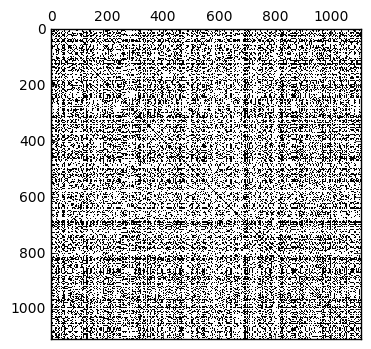

In [21]:
degrees = np.sum(weights, axis=0)
D = np.diag(degrees)
D_0_5 = np.diag(1./np.sqrt(degrees))
laplacian = np.dot(D_0_5, np.dot((D - weights), D_0_5))
plt.spy(laplacian)
plt.show()

**Eigenvalue decomposition** of the Laplacian.

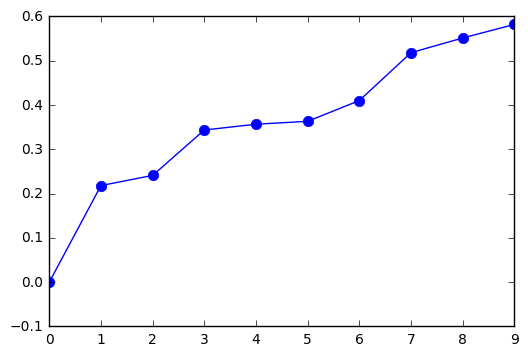

In [22]:
from scipy import sparse, stats, spatial
laplacian = sparse.csr_matrix(laplacian)
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, k=10, which='SM')
plt.plot(eigenvalues, '.-', markersize=15);

**Ground truth**: we label all of data in mac group as 0 and those in surface group as 1.

In [23]:
labels = np.ones(A.shape[0])
labels[0:n_mac] = 0

**Plot** the groud truth and the prediction based on spectral graph theory.

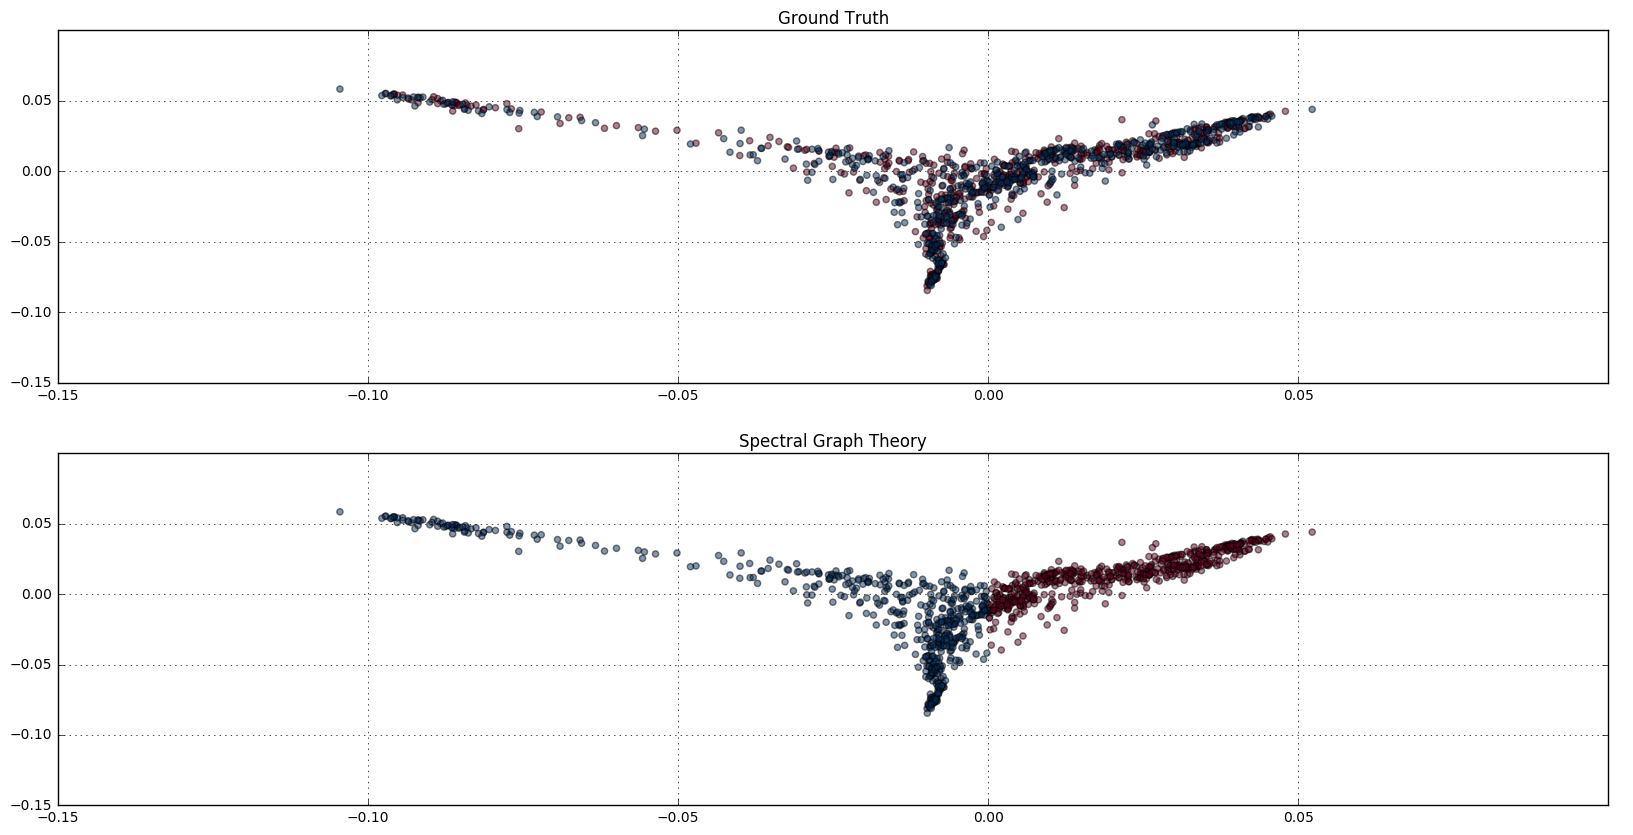

In [24]:
x1 = eigenvectors[:,1]
y1 = eigenvectors[:,2]
fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].scatter(x1, y1, c=labels, cmap='RdBu', alpha=0.5)
ax[0].set_title('Ground Truth')
ax[0].grid()
ax[1].scatter(x1, y1, c=(x1<0), cmap='RdBu', alpha=0.5)
ax[1].set_title('Spectral Graph Theory')
ax[1].grid()

**Error rate**

In [25]:
np.sum((x1<0) != labels)/len(labels)

0.50451263537906132

### **`Transductive Learning`**

In [26]:
# Ground truth.
x = np.ones(len(G.nodes))
x[0:n_mac] = -1

def prepare_observations(p):
    """Prepare observations, where p is the percentage of values to keep."""
    rs = np.random.RandomState(42)
    M = np.diag(rs.uniform(size=len(G.nodes)) < p)
    return M.dot(x)

# Play with the percentage of observed values.
y = prepare_observations(p=0.1)

In [27]:
def solve(y, alpha):
    """
    Solve the optimization problem.
    
    Parameters:
        y: the observations
        alpha: the balance between fidelity and smoothness prior.
    
    Returns:
        x_pred: the predicted class
        x_star: the solution of the optimization problem
    """
    
    M = np.diag(y!=0)
    
    x_star = np.linalg.solve(M+alpha*laplacian, M.dot(y))
    
    x_pred = np.ones(len(G.nodes))
    x_pred[x_star<0] = -1
    
    return x_pred, x_star

x_pred, x_star = solve(y, alpha=1)

# Be sure that the prediction is binary.
np.testing.assert_equal(abs(x_pred), 1)

# Error rate.
#err = np.sum(np.abs(x - x_pred))
err = np.sum(x != x_pred)
print('{} errors ({:.2%})'.format(err, err/len(G.nodes)))

453 errors (40.88%)


In [28]:
alpha = 0.1

for p in [0.1, 0.3, 0.5, 0.7, 0.9]:
    y = prepare_observations(p)
    x_pred, _ = solve(y, alpha)
    err = np.sum(x != x_pred)
    print('{}: {:6.2%}'.format(p, err/len(G.nodes)))

0.1: 40.88%
0.3: 29.96%
0.5: 22.47%
0.7: 12.55%
0.9:  4.33%


**Plot**

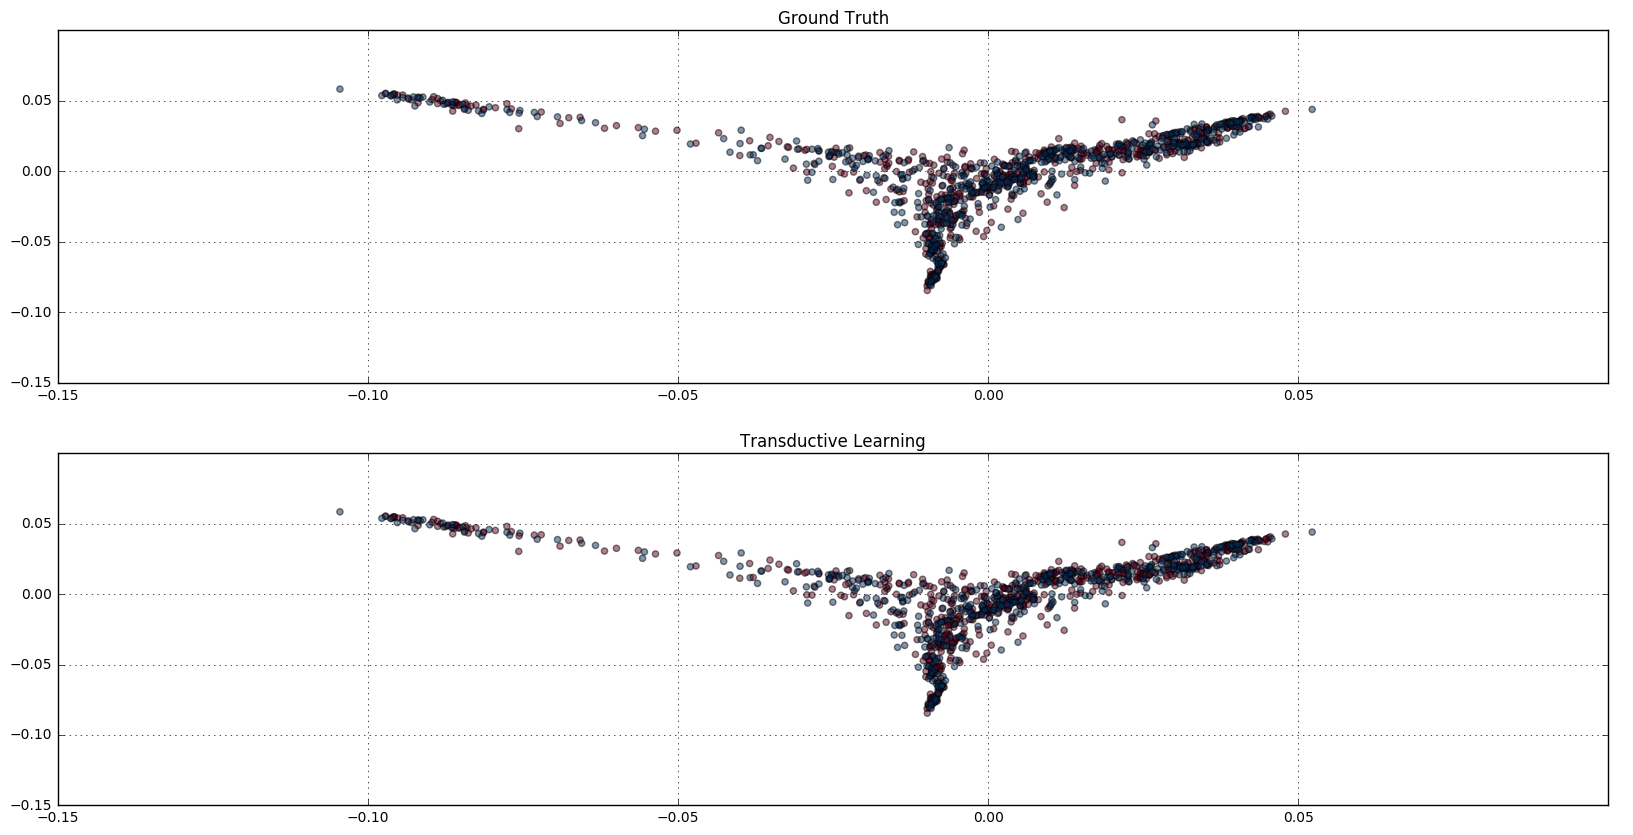

In [29]:
x1 = eigenvectors[:,1]
y1 = eigenvectors[:,2]
fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].scatter(x1, y1, c=labels, cmap='RdBu', alpha=0.5)
ax[0].set_title('Ground Truth')
ax[0].grid()
ax[1].scatter(x1, y1, c=x_pred, cmap='RdBu', alpha=0.5)
ax[1].set_title('Transductive Learning')
ax[1].grid()

### 2. Use both the information of 'also_bougtht' and 'reviewer'

In [30]:
df_review.head()

,reviewerID
asin,
B0083S3NC8,"[A18I2DO90GZCQY, A2C4BO8UURNWNN, A2RF9FHC4HC3J..."
B0047FHOWG,"[A3OTFTP2WVZVQY, A10KIQXOE926FN, A1Q165PZVZS34..."
B0067SJC80,"[A3QLALFN0WGF87, A395EVHF1TAQN0, AOEDXOKYPII2Z..."
B002WQP2IA,"[AN3ILH8NOGNH4, A3FGRP5N72WES1, ADN4437IJDIPP,..."
B006IC4YZQ,"[A3W3PWGZ36249Y, AZLDKR28KT3FB, A3M3DL4G9NS3Z2..."


Select the review information of data in our DataFrame.

In [43]:
df_review_chosen = df_review.loc[df_all.asin].reset_index()

Build the graph as we did above.

In [44]:
GB = nx.Graph()
GB.add_nodes_from(df_all.asin.values)

for i in range(len(df_all)):
    for j in range(i+1, len(df_all)):
        bou_len = len(set(df_all.iloc[i]['also_bought'])&set(df_all.iloc[j]['also_bought']))
        rer_len = len(set(df_review_chosen.iloc[i]['reviewerID'])&set(df_review_chosen.iloc[j]['reviewerID']))
        GB.add_edge(df_all.iloc[i]['asin'], df_all.iloc[j]['asin'], weight=0.8*bou_len+0.2*rer_len)

In [45]:
B = nx.adjacency_matrix(GB,weight='weight')
B.todense()

matrix([[ 0. ,  0. ,  0. , ...,  0. ,  0.8,  0.8],
        [ 0. ,  0. ,  0. , ...,  6.4,  0. ,  2.4],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        ..., 
        [ 0. ,  6.4,  0. , ...,  0. ,  4.8,  3.2],
        [ 0.8,  0. ,  0. , ...,  4.8,  0. ,  4. ],
        [ 0.8,  2.4,  0. , ...,  3.2,  4. ,  0. ]])

### `Basic properties of graph`

In [46]:
node_number = len(GB.nodes())
print('My network has {} nodes.'.format(node_number))
B_rw = B.copy()
B_rw[B>0] = 1
edge_number = int(np.sum(B_rw)/2)
print('My network has {} edges.'.format(edge_number))

My network has 1108 nodes.
My network has 287211 edges.


In [47]:
max_edge = node_number*(node_number-1)/2
print (max_edge)
rate = 1.0*edge_number/max_edge
print ("The rate of the real edge/max number of edge")
print (rate)

613278.0
The rate of the real edge/max number of edge
0.46832105505170574


The maximum number of links in a network with $N$ nodes is $L_{max}=N(N-1)/2$.Now we have about 50% of them.This graph is not very sparse.

**Degree distribution**

In [ ]:
d = B.todense().sum(axis=1)
plt.hist(d);

**The average degree is below**

In [ ]:
d_avg = np.sum(d)/len(d)
print (d_avg)

**Graph generate models**

Now wegenerate Erdős–Rényi and Barabási-Albert graph using NetworkX and compare with our graph

In [ ]:
er=nx.erdos_renyi_graph(node_number,rate)
ba=nx.barabasi_albert_graph(node_number,int(edge_number/node_number))

In [ ]:
print('My Erdős–Rényi network has {} nodes.'.format(len(er.nodes())))
print('My Erdős–Rényi network has {} edges.'.format(er.size()))
print('My Barabási-Albert network has {} nodes.'.format(len(ba.nodes())))
print('My Barabási-Albert network has {} edges.'.format(ba.size()))

In [ ]:
giant_GB = max(nx.connected_component_subgraphs(GB), key=len)
giant_er = max(nx.connected_component_subgraphs(er), key=len)
giant_ba = max(nx.connected_component_subgraphs(ba), key=len)
print(len(giant_GB.nodes()))
print(len(giant_er.nodes()))
print(len(giant_ba.nodes()))

In [ ]:
print (nx.average_clustering(GB))
print (nx.average_clustering(er))
print (nx.average_clustering(ba))

From the way we construct the graph, we can easily see that the graph is fully connected.Now we proved that.And also we can see that the generate models can't mimic the clustering coeffcient of real graph.

In [80]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

In [81]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]
i = 1
score=[]
error=[]

In [82]:
X, y = np.array(B.todense()),np.array(labels)
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X, y)
    score.append(clf.score(X_test, y_test))
    names.append(name)


C:\Program Files\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[0.77027027027027029, 0.98648648648648651, 1.0, 1.0, 0.65540540540540537, 0.63513513513513509, 0.98423423423423428, 0.7432432432432432, 0.59459459459459463, 1.0]


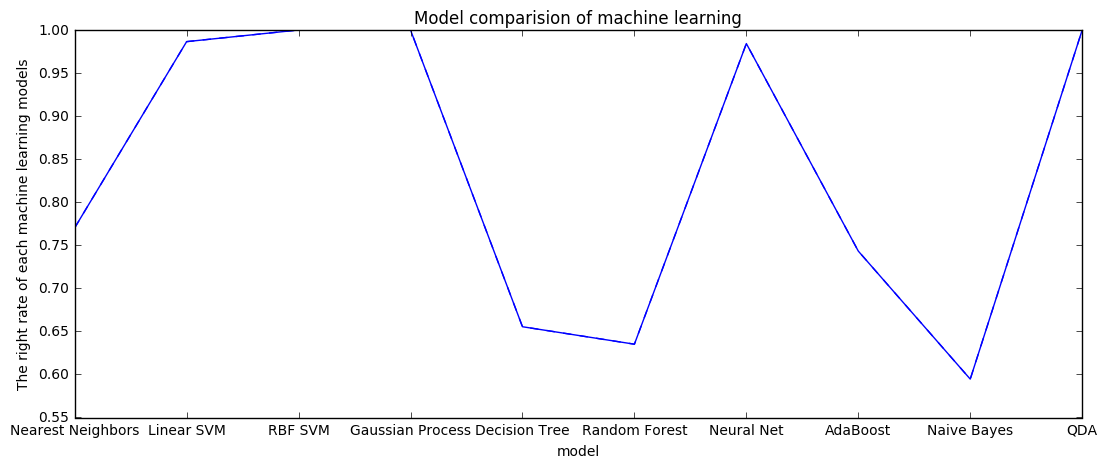

In [96]:
print (score)
plt.figure(figsize=(13,5)) 
plt.plot(range(len(score)),score,"b--",linewidth=1)      
plt.xlabel("model") 
plt.ylabel("The right rate of each machine learning models")  
plt.title("Model comparision of machine learning") 
plt.xticks(range(len(score)), names )
plt.plot(range(len(score)),score)

Now we can see that different machine learning models varies a lot in this problem.The SVM and QDA have a good result.Let's visualize
the result of QDA in the following part.

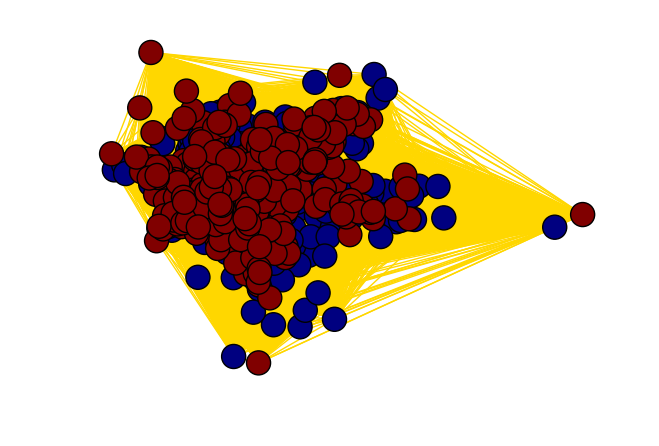

In [106]:
nx.draw(GB,node_color=clf.predict(X),edge_color='gold')

### `Spectral Graph Theory`

**Similarity Matrix**

In [173]:
B.max()

43.600000000000001

In [195]:
similarB = B.todense()/B.max()
np.fill_diagonal(similarB,0)

**TOP K Neighbors**

In [196]:
weights = similarB.getA().copy()
NEIGHBORS = 300

# Keep only the K strongest edges
# By making weights of all other edges equal to 0
ind = np.argsort(weights)[:,::-1][:,NEIGHBORS:]
for i in range(weights.shape[1]):
    weights[i][ind[i]]=0
    
# Make it symmestric
bigger = weights.transpose() > weights
weights = weights - weights*bigger + weights.transpose()*bigger

**Calculate Laplacian**

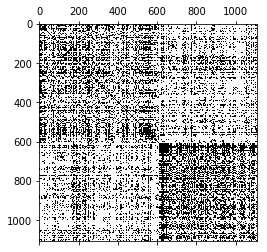

In [197]:
degrees = np.sum(weights, axis=0)
D = np.diag(degrees)
D_0_5 = np.diag(1./np.sqrt(degrees))
laplacian = np.dot(D_0_5, np.dot((D - weights), D_0_5))
plt.spy(laplacian)
plt.show()

**Eigenvalue Decomposition**

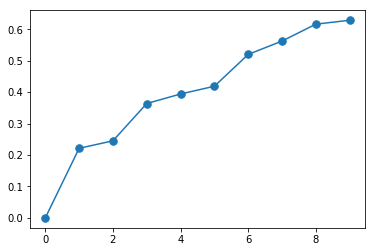

In [198]:
from scipy import sparse, stats, spatial
laplacian = sparse.csr_matrix(laplacian)
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, k=10, which='SM')
plt.plot(eigenvalues, '.-', markersize=15);

**Plot**

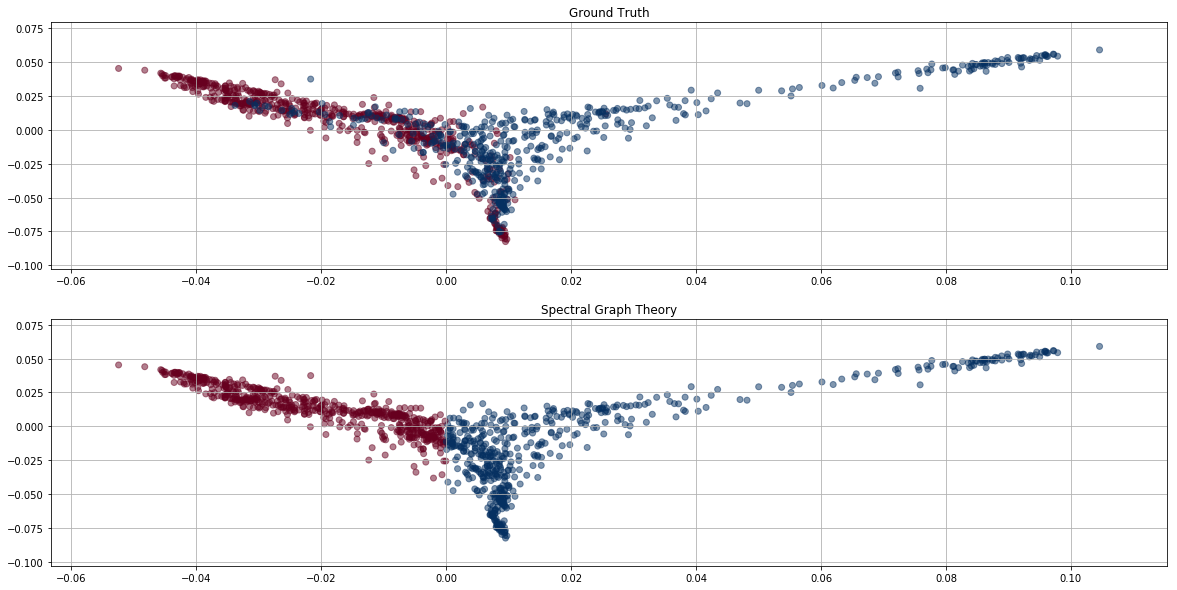

In [199]:
x2 = eigenvectors[:,1]
y2 = eigenvectors[:,2]
fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].scatter(x2, y2, c=labels, cmap='RdBu', alpha=0.5)
ax[0].set_title('Ground Truth')
ax[0].grid()
ax[1].scatter(x2, y2, c=(x2>0), cmap='RdBu', alpha=0.5)
ax[1].set_title('Spectral Graph Theory')
ax[1].grid()

**Error Rate**

In [200]:
np.sum((x2>0)!=labels)/len(labels)

0.17509025270758122